# Build a Regression Model - PyTorch

| [Story](https://www.pivotaltracker.com/story/show/188279486) | [Source](https://machinelearningmastery.com/building-a-regression-model-in-pytorch/) | [Dataset](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset) |


#### Load Data

In [10]:
from sklearn.datasets import fetch_california_housing

data = fetch_california_housing()
print(data.feature_names)

['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


In [11]:
X, y = data.data, data.target

#### Build Model

In [12]:
import torch.nn as nn

model = nn.Sequential(
    nn.Linear(8,24),
    nn.ReLU(),
    nn.Linear(24, 12),
    nn.ReLU(),
    nn.Linear(12, 6),
    nn.ReLU(),
    nn.Linear(6, 1),
)

#### Train Model

In [13]:
# Train Model
import copy
import numpy as np
import torch
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# split data to tran and test
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

# data standardizatiion
scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

# convert splits to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1,1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1,1)

# Training params
n_epochs = 15
batch_size = 10
batch_start = torch.arange(0, len(X_train), batch_size)

# CPU paralleization
import multiprocessing
number_of_threats = multiprocessing.cpu_count()
MKL_NUM_THREADS = number_of_threats
torch.set_num_threads(number_of_threats) 

# Hold best model
best_mse = np.inf 
best_weights = None
history = []

In [14]:
# Loss Function
import torch.optim as optim

loss_fn = nn.MSELoss() # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
# Training Loop
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=False) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # Take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # Evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

# restore model and return best accuracy
model.load_state_dict(best_weights)

Epoch 0:  83%|████████████████████████▊     | 1193/1445 [00:11<00:02, 106.51batch/s, mse=4.13]

MSE: 0.78
RMSE: 0.88


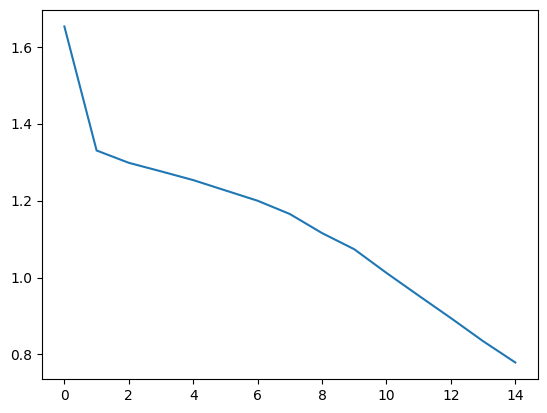

In [8]:
import matplotlib.pyplot as plt

print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [ ]:
model.eval()
with torch.no_grad():
    for i in range(5):
        X_sample = X:test_raw[i: i+1]
        X_sample = scaler.transform(X_sample)
        X_sample = torch.tensor(X_sample, dtype=torch.float32)
        y_pred = model(X_sample)
        print(f"{X_test_raw[i]} -> {y_pred[0].numpy()} (expected {y_test[i].numpy()})")

#### Improve th Model

Due to it's diverse data nature, this model is hard to improve.  It's better to use `standard scaler`,  convert each feature to it's standard score.  for each feature X replace with 

$$
Z =\frac{ X- \hat{X}}{\sigma{x}}
$$